**Haritha - The Chatbot**

Many Popular online food delivery platforms that operate in several countries utilize chatbots to enhance their customer experience and provide quick and efficient support to their users. This project aims to creat a mini - Chatbot named **Haritha** with the intension to mimic the chatbots of food delivery platforms

In [36]:
import json
import string
import random
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
#Loading intents.json
with open('intents.json') as intents:
  data = json.load(intents)


In [38]:
# initializing lemmatizer to get stem of words
lemmatizer = WordNetLemmatizer()
# Each list to create
words = []
classes = []
doc_X = []
doc_y = []
# Loop through all the intents
# tokenize each pattern and append tokens to words, the patterns and
# the associated tag to their associated list
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # add the tag to the classes if it's not there already
    if intent["tag"] not in classes:
        classes.append(intent["tag"])
# lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]
# sorting the vocab and classes in alphabetical order and taking the # set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))

In [39]:
# list for training data
training = []
out_empty = [0] * len(classes)
# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # mark the index of class that the current pattern is associated
    # to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # add the one hot encoded BoW and associated classes to training
    training.append([bow, output_row])
# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)
# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [40]:

# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 500
# the deep learning model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
#adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])
print(model.summary())

history = model.fit(x=train_X, y=train_y, epochs=500, verbose=1)

#model.fit(x=train_X, y=train_y, epochs=500, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               21248     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 30)                1950      
                                                                 
Total params: 31,454
Trainable params: 31,454
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
4/4 [============================

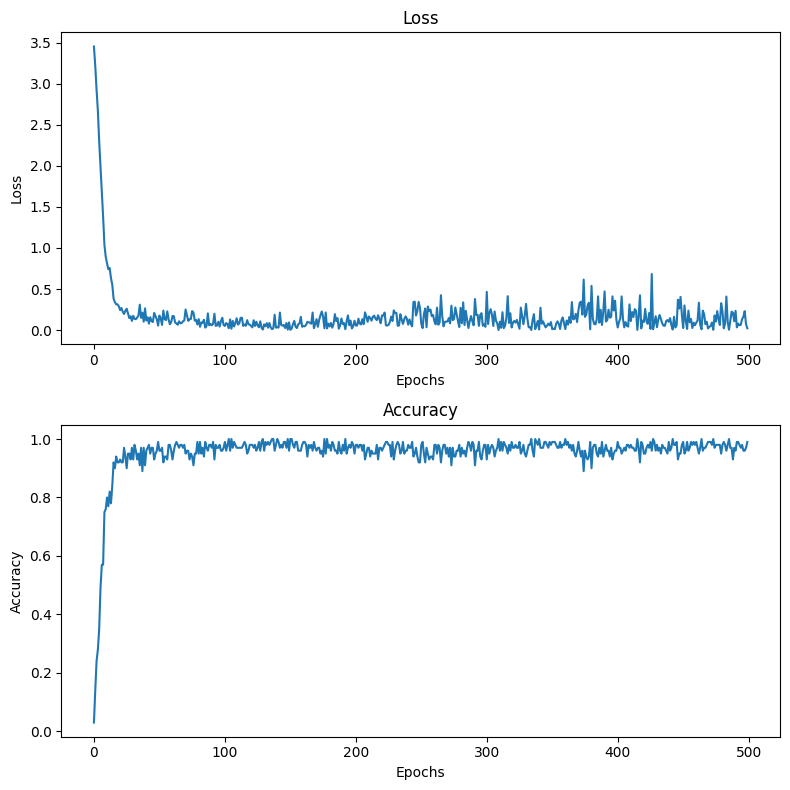

In [41]:
import matplotlib.pyplot as plt

# Retrieve loss and accuracy values from the history object
loss = history.history['loss']
accuracy = history.history['accuracy']

# Create a figure and axes for the plots
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# Plot the loss graph
ax[0].plot(loss)
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

# Plot the accuracy graph
ax[1].plot(accuracy)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [42]:
def clean_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab):
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens:
    for idx, word in enumerate(vocab):
      if word == w:
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels):
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json):
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents:
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

In [43]:
exit_commands = ["exit", "quit", "bye"]
is_user_message = True

while True:
    if is_user_message:
        message = input("User: ")
    else:
        message = ""

    # Check if the user input matches any exit commands
    if message.lower() in exit_commands:
        print("Bot: Goodbye!")
        break

    if is_user_message:
        # Process the user input and generate a response
        intents = pred_class(message, words, classes)
        result = get_response(intents, data)
        print("Bot:", result)
        is_user_message = False
    else:
        is_user_message = True


User: hi
1/1 [==============================] - 0s 67ms/step
Bot: Hello
User: who are you
1/1 [==============================] - 0s 37ms/step
Bot: I'm Haritha, an Artificial Intelligent bot.
User: ok i need a help
1/1 [==============================] - 0s 36ms/step
Bot: Yes, sure! How can I support you?
User: my order is delayed
1/1 [==============================] - 0s 25ms/step
Bot: We apologize for the delay in delivering your order. Kindly provide your order details, and we'll look into it and provide you with an update.
User: i want to cancel the order
1/1 [==============================] - 0s 29ms/step
Bot: You can cancel your order by visiting the 'Order History' section of your account. Locate the order you wish to cancel and choose the cancellation option. The necessary steps will be provided to you.
User: will i get the refund?
1/1 [==============================] - 0s 23ms/step
Bot: To initiate a refund, please contact our customer support team with your order details. They 